In [2]:
import torch
import numpy as np
from pathlib import Path

MODEL_NAME = "leaf-enet-birdclef2021"
MODEL_PATH = Path(f"../scratch/leaf_experiments/models/{MODEL_NAME}")
DEVICE = "cpu"

args = {}
with open(MODEL_PATH / "args.txt", "r") as f:
    for line in f:
        key, value = line.split("=")
        try:
            args[key] = float(value.strip())
        except ValueError:
            args[key] = value.strip()
            
metrics = {}
with open(MODEL_PATH / "final_metrics.txt", "r") as f:
    for line in f:
        key, value = line.split("=")
        try:
            metrics[key] = float(value.strip())
        except ValueError:
            metrics[key] = value.strip()
            
model = torch.load(MODEL_PATH / "net_last_model.pth")
network = model['network']
device = torch.device(DEVICE)
# network.to(device)

# config
n_classes = args['nb_classes']

## fix the seed for reproducibility
seed = 2026
torch.manual_seed(seed)
np.random.seed(seed)

# Build dataset
# TODO
# print(model.keys())
print(network.keys())
# print(network.forward)

/tmp/ipykernel_2715696/3803572430.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH / "net_last_model.pth")


odict_keys(['_frontend.filterbank.center_freqs', '_frontend.filterbank.bandwidths', '_frontend.filterbank.pooling_widths', '_frontend.compression.s', '_frontend.compression.alpha', '_frontend.compression.delta', '_frontend.compression.r', '_encoder._conv_stem.weight', '_encoder._bn0.weight', '_encoder._bn0.bias', '_encoder._bn0.running_mean', '_encoder._bn0.running_var', '_encoder._bn0.num_batches_tracked', '_encoder._blocks.0._depthwise_conv.weight', '_encoder._blocks.0._bn1.weight', '_encoder._blocks.0._bn1.bias', '_encoder._blocks.0._bn1.running_mean', '_encoder._blocks.0._bn1.running_var', '_encoder._blocks.0._bn1.num_batches_tracked', '_encoder._blocks.0._se_reduce.weight', '_encoder._blocks.0._se_reduce.bias', '_encoder._blocks.0._se_expand.weight', '_encoder._blocks.0._se_expand.bias', '_encoder._blocks.0._project_conv.weight', '_encoder._blocks.0._bn2.weight', '_encoder._blocks.0._bn2.bias', '_encoder._blocks.0._bn2.running_mean', '_encoder._blocks.0._bn2.running_var', '_encode

In [3]:
from model.leaf import Leaf, PCEN
n_filters = 40
sample_rate = 16000
window_len = 25.0
window_stride = 10.0
min_freq = 60.0
max_freq = 7800.0
compression_fn = PCEN(num_bands=n_filters,
                              s=0.04,
                              alpha=0.96,
                              delta=2.0,
                              r=0.5,
                              eps=1e-12,
                              learn_logs=args['pcen_learn_logs'] == 'True',
                              clamp=1e-5)
def_frontend = Leaf(n_filters=n_filters,
                min_freq=min_freq,
                max_freq=max_freq,
                sample_rate=sample_rate,
                window_len=window_len,
                window_stride=window_stride,
                compression=compression_fn)

In [4]:
network['_frontend.filterbank.center_freqs']

tensor([0.0085, 0.0474, 0.0591, 0.0896, 0.1262, 0.1554, 0.1822, 0.2078, 0.2348,
        0.2639, 0.3014, 0.3377, 0.3737, 0.4163, 0.4533, 0.4966, 0.5387, 0.5846,
        0.6354, 0.6944, 0.7524, 0.8148, 0.8819, 0.9524, 1.0272, 1.0976, 1.1793,
        1.2783, 1.3754, 1.4704, 1.5669, 1.6798, 1.8245, 1.9361, 2.0708, 2.2228,
        2.3775, 2.5178, 2.7223, 2.9583], device='cuda:0')

In [5]:
def_frontend.filterbank.center_freqs

Parameter containing:
tensor([0.0417, 0.0609, 0.0812, 0.1028, 0.1257, 0.1501, 0.1758, 0.2032, 0.2322,
        0.2629, 0.2955, 0.3301, 0.3668, 0.4058, 0.4471, 0.4909, 0.5373, 0.5866,
        0.6388, 0.6943, 0.7530, 0.8154, 0.8815, 0.9517, 1.0261, 1.1050, 1.1887,
        1.2775, 1.3716, 1.4715, 1.5775, 1.6898, 1.8090, 1.9354, 2.0695, 2.2117,
        2.3625, 2.5225, 2.6922, 2.8722], requires_grad=True)

## Comparing Learned Parameters

Here we compare how parameters in the frontend have changed from initialization using our trained model and a newly initialized LEAF frontend.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

### Gabor Filterbank

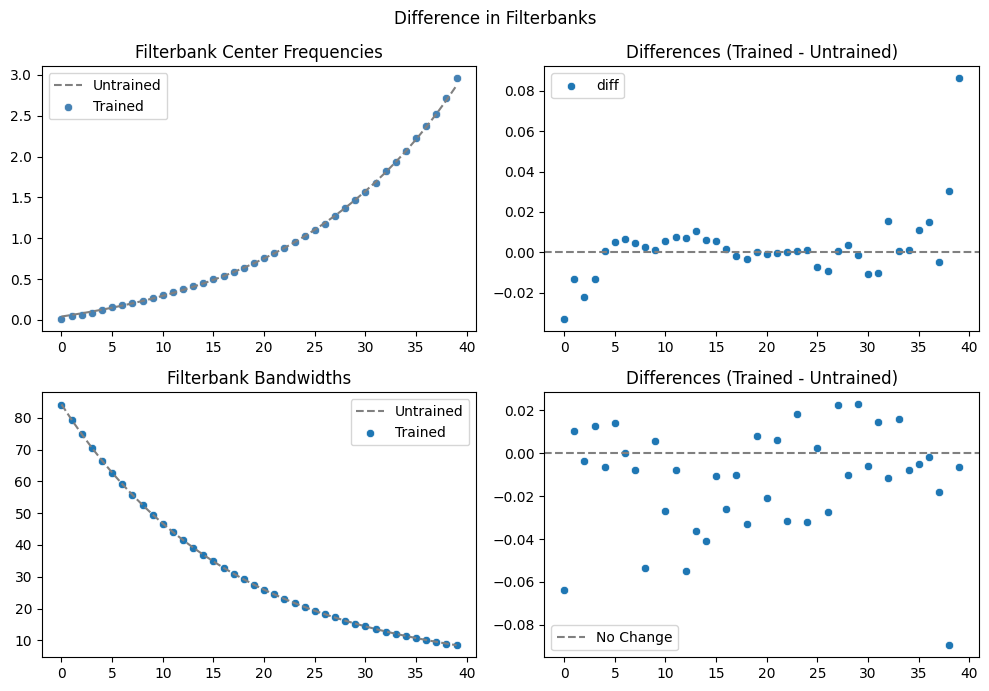

In [99]:
fig, axs = plt.subplots(2,2, figsize=(10, 7))
axs = [ax for row in axs for ax in row]
axs[0].set_title('Filterbank Center Frequencies')
sns.lineplot(data=def_frontend.filterbank.center_freqs.cpu().detach().numpy(), 
                label="Untrained", ax=axs[0], color='grey', linestyle="--")
sns.scatterplot(data=network['_frontend.filterbank.center_freqs'].cpu().detach().numpy(), 
                label="Trained", ax=axs[0], color='steelblue')

axs[1].set_title('Differences (Trained - Untrained)')
sns.scatterplot(data=network['_frontend.filterbank.center_freqs'].cpu().detach().numpy() 
             - def_frontend.filterbank.center_freqs.cpu().detach().numpy(), label="diff", ax=axs[1])
axs[1].axhline(y=0, color='grey', linestyle='--')

axs[2].set_title('Filterbank Bandwidths')
sns.lineplot(data=def_frontend.filterbank.bandwidths.cpu().detach().numpy(), 
                label="Untrained", ax=axs[2], color='grey', linestyle='--')
sns.scatterplot(data=network['_frontend.filterbank.bandwidths'].cpu().detach().numpy(), 
                label="Trained", ax=axs[2])

axs[3].set_title('Differences (Trained - Untrained)')
sns.scatterplot(data=network['_frontend.filterbank.bandwidths'].cpu().detach().numpy() 
             - def_frontend.filterbank.bandwidths.cpu().detach().numpy(), ax=axs[3])
axs[3].axhline(y=0, color='grey', linestyle='--', label="No Change")
axs[3].legend()
plt.suptitle("Difference in Filterbanks")
plt.tight_layout()

Text(0.5, 0.98, 'Difference in Filterbank Bandwidths')

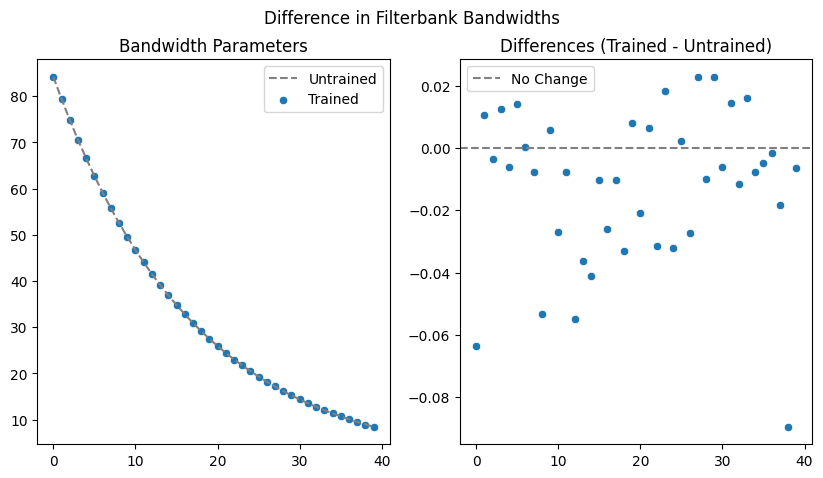

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].set_title('Bandwidth Parameters')
sns.lineplot(data=def_frontend.filterbank.bandwidths.cpu().detach().numpy(), 
                label="Untrained", ax=axs[0], color='grey', linestyle='--')
sns.scatterplot(data=network['_frontend.filterbank.bandwidths'].cpu().detach().numpy(), 
                label="Trained", ax=axs[0])

axs[1].set_title('Differences (Trained - Untrained)')
sns.scatterplot(data=network['_frontend.filterbank.bandwidths'].cpu().detach().numpy() 
             - def_frontend.filterbank.bandwidths.cpu().detach().numpy(), ax=axs[1])
axs[1].axhline(y=0, color='grey', linestyle='--', label="No Change")
axs[1].legend()
plt.suptitle("Difference in Filterbank Bandwidths")

### Lowpass Filtering (Pooling)

Text(0.5, 0.98, 'Difference in Pooling Bandwidths')

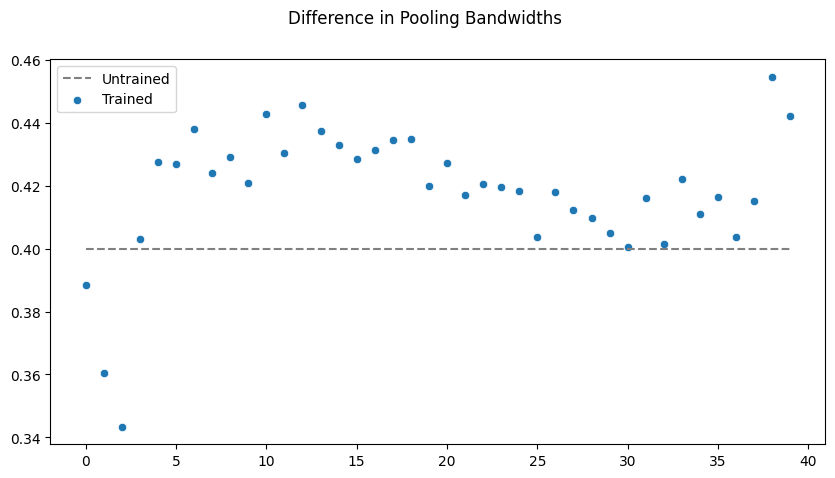

In [9]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.lineplot(data=def_frontend.filterbank.pooling_widths.cpu().detach().numpy(), 
                label="Untrained", ax=axs, color='grey', linestyle='--')
sns.scatterplot(data=network['_frontend.filterbank.pooling_widths'].cpu().detach().numpy(), 
                label="Trained", ax=axs)
plt.suptitle("Difference in Pooling Bandwidths")

### PCEN (Compression)

Text(0.5, 0.98, 'Difference in Compression Alpha')

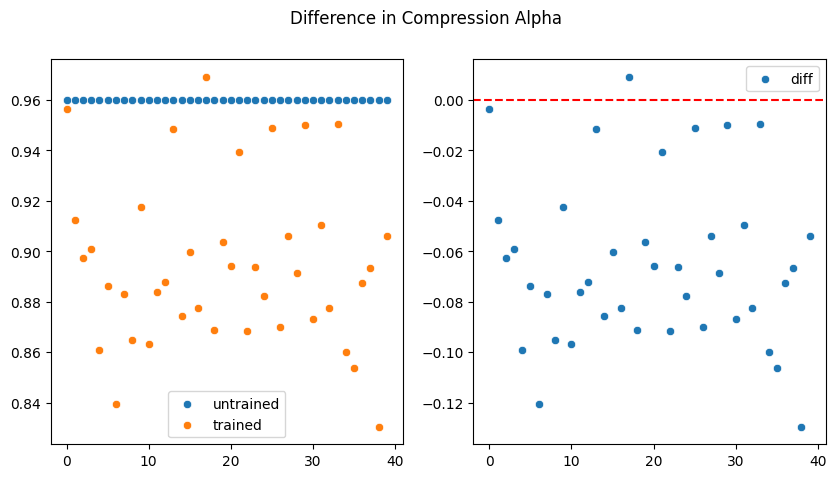

In [10]:
network['_frontend.compression.alpha']
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.scatterplot(data=def_frontend.compression.alpha.cpu().detach().numpy(), label="untrained", ax=axs[0])
sns.scatterplot(data=network['_frontend.compression.alpha'].cpu().detach().numpy(), label="trained", ax=axs[0])
sns.scatterplot(data=network['_frontend.compression.alpha'].cpu().detach().numpy() 
             - def_frontend.compression.alpha.cpu().detach().numpy(), label="diff", ax=axs[1])
axs[1].axhline(y=0, color='red', linestyle='--')
plt.suptitle("Difference in Compression Alpha")

Text(0.5, 0.98, 'Difference in Compression Delta')

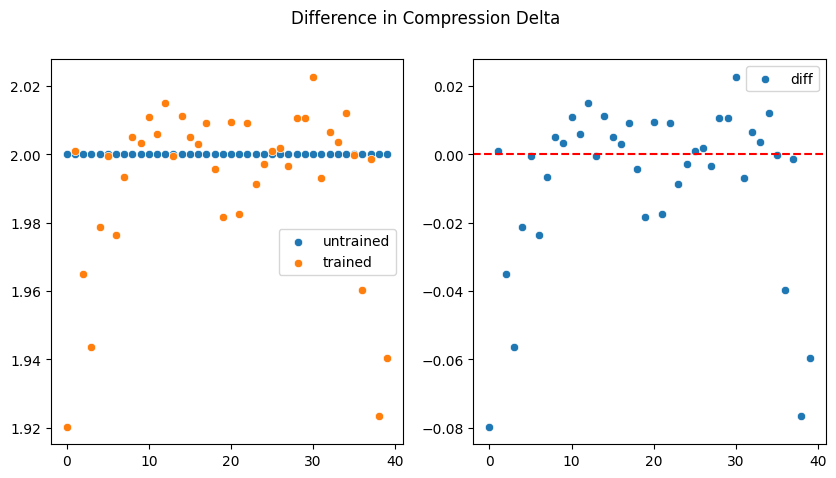

In [11]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.scatterplot(data=def_frontend.compression.delta.cpu().detach().numpy(), label="untrained", ax=axs[0])
sns.scatterplot(data=network['_frontend.compression.delta'].cpu().detach().numpy(), label="trained", ax=axs[0])
sns.scatterplot(data=network['_frontend.compression.delta'].cpu().detach().numpy() 
             - def_frontend.compression.delta.cpu().detach().numpy(), label="diff", ax=axs[1])
axs[1].axhline(y=0, color='red', linestyle='--')
plt.suptitle("Difference in Compression Delta")

Text(0.5, 0.98, 'Difference in Compression r')

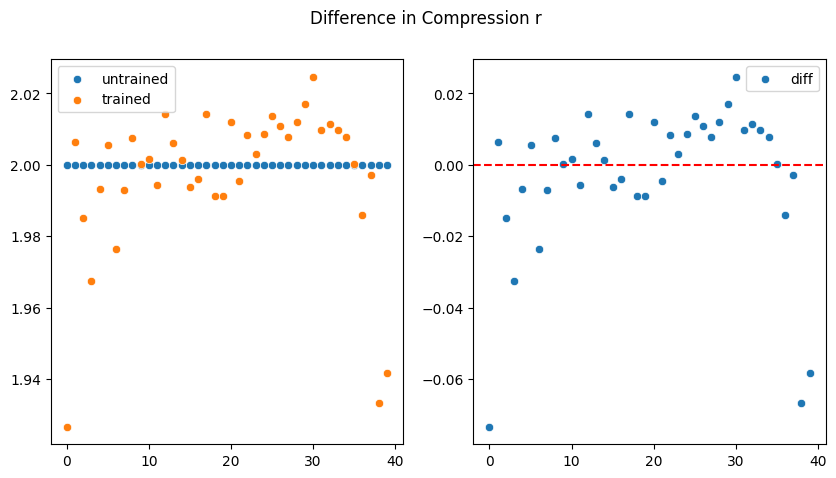

In [12]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.scatterplot(data=def_frontend.compression.r.cpu().detach().numpy(), label="untrained", ax=axs[0])
sns.scatterplot(data=network['_frontend.compression.r'].cpu().detach().numpy(), label="trained", ax=axs[0])
sns.scatterplot(data=network['_frontend.compression.r'].cpu().detach().numpy() 
             - def_frontend.compression.r.cpu().detach().numpy(), label="diff", ax=axs[1])
axs[1].axhline(y=0, color='red', linestyle='--')
plt.suptitle("Difference in Compression r")

## Converting to Units

Current parameters aren't in interpretable units... need to convert them into proper filters/units to see how big differences are

In [13]:
from model.leaf import *

In [14]:
learned_gabor_centers = network['_frontend.filterbank.center_freqs'].cpu().detach()
learned_gabor_bandwidths = network['_frontend.filterbank.bandwidths'].cpu().detach()
n_filters = len(learned_gabor_centers)
gabor_filters(n_filters, learned_gabor_centers, learned_gabor_bandwidths)

tensor([[ 0.0045-0.0008j,  0.0046-0.0007j,  0.0046-0.0007j,  ...,
          0.0046+0.0007j,  0.0046+0.0007j,  0.0046+0.0007j],
        [ 0.0028-0.0040j,  0.0030-0.0038j,  0.0032-0.0037j,  ...,
          0.0034+0.0035j,  0.0032+0.0037j,  0.0030+0.0038j],
        [ 0.0020-0.0048j,  0.0022-0.0046j,  0.0025-0.0045j,  ...,
          0.0028+0.0044j,  0.0025+0.0045j,  0.0022+0.0046j],
        ...,
        [ 0.0046-0.0004j, -0.0043+0.0037j,  0.0016-0.0068j,  ...,
          0.0032-0.0079j,  0.0016+0.0068j, -0.0043-0.0037j],
        [-0.0018+0.0031j,  0.0005-0.0046j,  0.0018+0.0055j,  ...,
         -0.0048+0.0054j,  0.0018-0.0055j,  0.0005+0.0046j],
        [-0.0025-0.0014j,  0.0036+0.0013j, -0.0049-0.0008j,  ...,
          0.0063+0.0002j, -0.0049+0.0008j,  0.0036-0.0013j]])

In [108]:
class PCENFunc:
    def __init__(self, num_bands=40, alpha=None, delta=None, r=None):
        self.alpha = torch.full((num_bands,), float(0.96)) if alpha is None else alpha
        self.alpha = self.alpha.clamp(max=1)
        
        self.delta = torch.full((num_bands,), float(2)) if delta is None else delta
        self.delta = self.delta.clamp(min=0)
        
        self.r = torch.full((num_bands,), float(0.5)) if r is None else r
        self.r = 1. / self.r.clamp(min=1)
    
    def __call__(self, energy):
        return ((energy / (energy ** self.alpha) + 1e-10) + self.delta)**self.r - self.delta ** self.r

In [109]:
learned_pcen = PCENFunc(
    alpha=network['_frontend.compression.alpha'].cpu().detach(),
    delta=network['_frontend.compression.delta'].cpu().detach(),
    r=network['_frontend.compression.r'].cpu().detach()
)
base_pcen = PCENFunc()
learned_results = []
base_results = []
for energy in torch.arange(0, 30, 1):
    learned_results.append(learned_pcen(energy))
    base_results.append(base_pcen(energy))
learned_results = torch.stack(learned_results)
base_results = torch.stack(base_results)
learned_results.size()

torch.Size([30, 40])

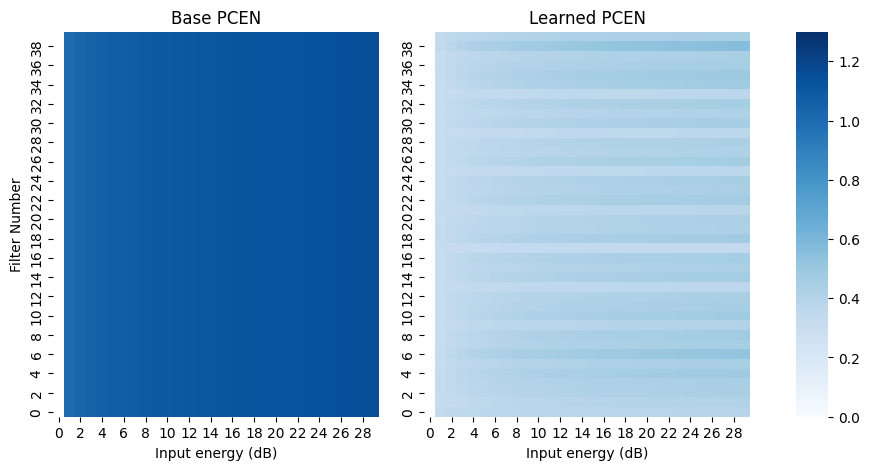

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5),
                        gridspec_kw={'width_ratios': [10, 10, 1]})
cmap='Blues'
vmin = 0
vmax = 1.3
axs[0].set_title("Base PCEN")
base_plot = sns.heatmap(base_results.T, ax=axs[0], cmap=cmap,
                        vmin=vmin, vmax=vmax, cbar=False)
axs[0].set_ylabel("Filter Number")
axs[0].set_xlabel("Input energy (dB)")
axs[0].invert_yaxis()

axs[1].set_title("Learned PCEN")
learned_plot = sns.heatmap(learned_results.T, ax=axs[1], cmap=cmap,
                           vmin=vmin, vmax=vmax, cbar_ax=axs[2])
axs[1].set_xlabel("Input energy (dB)")
axs[1].invert_yaxis()

## Computing Representations

In [52]:
import torchaudio
from model import *
from model.mel import *
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict
n_classes = 397
n_filters = 40
seconds = 7
window_len = 25.0
window_stride = 10.0
min_freq = 60.0
max_freq = 7800.0

In [53]:
frontend = Leaf(n_filters = n_filters)
encoder = EfficientNet.from_name("efficientnet-b0", num_classes=n_classes, include_top=False,
                                     in_channels=1)
model = AudioClassifier(num_outputs=n_classes,
                        frontend=frontend,
                        encoder=encoder)
weights = torch.load(MODEL_PATH / "net_last_model.pth", weights_only=True)['network']

In [54]:
data_path = "XC1032441 - Screaming Piha - Lipaugus vociferans.mp3"
audio, sr = torchaudio.load(data_path)
audio = audio[:1, :sr * seconds]
audio = audio.to("cuda")
audio.size()

torch.Size([1, 336000])

In [ ]:
model.load_state_dict(weights)
model = model.to("cuda")
frontend = model._frontend
base_frontend = Leaf(n_filters = n_filters).to("cuda")
melspec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                         n_mels=n_filters,
                                                         hop_length=int(sr * window_stride / 1000 + 1))

In [72]:
trained_representation = frontend(audio).detach().cpu()
base_representation = base_frontend(audio).detach().cpu()
melspec = melspec_transform(audio.detach().cpu())

In [73]:
trained_representation.size(), base_representation.size(), melspec.size()

(torch.Size([1, 40, 2100]),
 torch.Size([1, 40, 2100]),
 torch.Size([1, 40, 699]))

In [80]:
torch.stack([base_representation[0], trained_representation[0]]).flatten()

tensor([0.2078, 0.2078, 0.2078,  ..., 0.1218, 0.1218, 0.1218])

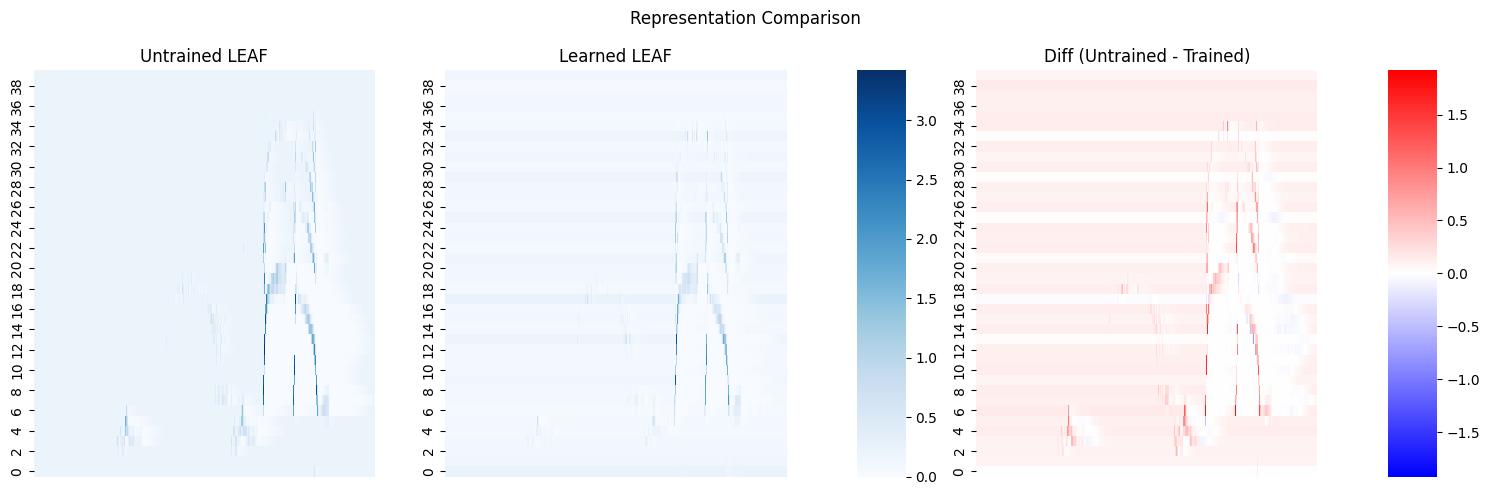

In [93]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5), 
                        gridspec_kw={'width_ratios': [7, 7, 1, 7, 1]})
cmap='Blues'
vmin = 0
vmax = max(torch.stack([base_representation[0], trained_representation[0]]).flatten())
axs[0].set_title("Untrained LEAF")
base_plot = sns.heatmap(base_representation[0], ax=axs[0], cmap=cmap,
                        vmin=vmin, vmax=vmax, cbar=False)

axs[1].set_title("Learned LEAF")
learned_plot = sns.heatmap(trained_representation[0], ax=axs[1], cmap=cmap,
                           vmin=vmin, vmax=vmax, cbar_ax=axs[2])

axs[3].set_title("Diff (Untrained - Trained)")
cbar_limit = (base_representation[0] - trained_representation[0]).flatten().abs().max()
melspec_plot = sns.heatmap(base_representation[0] - trained_representation[0], ax=axs[3], cmap="bwr",
                        vmin=-cbar_limit, vmax=cbar_limit, cbar_ax=axs[4])
for ax in [axs[0], axs[1], axs[3]]:
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
plt.suptitle("Representation Comparison")
plt.tight_layout()